In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.abspath(".."))

# 확인: 경로가 잘 추가되었는지 출력
print("시스템 경로 추가 완료:", os.path.abspath(".."))

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

from react_reflexion.state import NegotiationState
from react_reflexion.nodes import (
    negotiator_node,
    evaluation_node,
    reflection_node,
    setup_node
)

시스템 경로 추가 완료: c:\Users\c\Desktop\workspace\Nego-interface


In [2]:
def route_after_negotiation(state: NegotiationState):
    """
    협상 노드가 끝난 후 어디로 갈지 결정
    """
    if state.get("is_finished"):
        return "evaluator"
    
    return END

def route_after_evaluation(state: NegotiationState):
    """
    평가 후 어디로 갈지 결정
    """
    total_score = state.get("buyer_score", 0) + state.get("seller_score", 0)

    if total_score >= 150:
        return END
    
    return "reflector"

In [5]:
def build_reflexion_graph():
    workflow = StateGraph(NegotiationState)

    workflow.add_node("setup", setup_node)
    workflow.add_node("negotiator", negotiator_node)
    workflow.add_node("evaluator", evaluation_node)
    workflow.add_node("reflector", reflection_node)
    
    # [Start] -> [Setup] 
    workflow.add_edge(START, "setup")
    
    # [Setup] -> [Negotiator]
    workflow.add_edge("setup", "negotiator")

    # [Negotiator] -> [분기점] (계속 대화 or 평가?)
    workflow.add_conditional_edges(
        "negotiator",
        route_after_negotiation,
        {
            END: END,        
            "evaluator": "evaluator" 
        }
    )

    # [Evaluator] -> [분기점] (성공 or 반성?)
    workflow.add_conditional_edges(
        "evaluator",
        route_after_evaluation,
        {
            END: END,            # 성공해서 종료
            "reflector": "reflector" # 실패해서 반성
        }
    )

    # [Reflector] -> [Setup] (핵심: 반성 후 재시작!)
    # 반성 내용을 들고 Setup으로 가서 'reflections'만 남기고 메모리 리셋
    workflow.add_edge("reflector", "setup")

    return workflow.compile()

# 그래프 생성
app = build_reflexion_graph()
print("Reflexion 그래프 생성 완료!")

Reflexion 그래프 생성 완료!


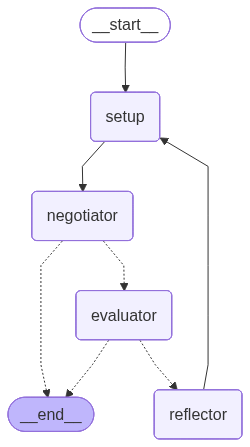

In [4]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("이미지 렌더링 실패, 텍스트로 출력합니다.")
    print(app.get_graph().draw_mermaid())